### Pade objective builder function

In [1]:
using Symbolics
using LinearAlgebra
using DynamicPolynomials

Auxilary function for square Frobenius norm of the matrix $\left\| M \right\|_F^2$:

In [2]:
function frobenius_norm2(m)
    return tr(m * m')
end

frobenius_norm2 (generic function with 1 method)

Lindblad master equation is given by
\begin{align}\label{eq:L1}
    \frac{d}{dt}{\rho}(t) = \mathcal{L}\rho(t),
\end{align}

where Lindbladian right hand side operator is given as
\begin{align}
    \mathcal{L} [\rho] = - \frac{i}{\hbar}[H, \rho]+\sum_{j=1}^{\ell}\left[ J_j \rho J_j^\dagger - \frac{1}{2}\left\{ J_j^\dagger J_j, \rho \right\} \right],
\end{align}

\begin{align}
\sum_{i=1}^N {
{\left\|
\rho_{(i)} - \rho_{(i-1)}
- {\mathcal{L}} \left[\int^{i\Delta t}_{(i-1)\Delta t}\rho(t)dt \right] \right\| }^2_F } \rightarrow \operatorname{min}
\end{align}

In [3]:
function lindblad_rhs(ρ, H, J)
    """
    Right hand side of the Lindblad master equation
    """
    return -im*(H * ρ - ρ * H) + J * ρ * J' - (J' * J  * ρ + ρ * J' * J) / 2
    
end

lindblad_rhs (generic function with 1 method)

Terms for the objective for minimization:
\begin{align}
{\rho_{(i)} - \rho_{(i-1)} - \Delta t \mathcal{L} \left[\frac{{\rho}_{(i)} + {\rho}_{(i-1)}}{2} \right]} \rightarrow \operatorname{min}
\end{align}

In [4]:
function pade_obj(ρ::Array{ComplexF64,3}, t)
    @polyvar x[1:4]
    H = [ 1.0 * x[1]              x[3] + im * x[4]
          x[3] - im * x[4]        x[2]             ]

    @polyvar a[1:2, 1:2]
    @polyvar b[1:2, 1:2]
    J = 1.0 * a + im * b
    
    obj = 0
    for i in 2:size(ρ,3)
        obj += frobenius_norm2(
            ρ[:, :, i] - ρ[:, :, i-1] 
            - (t[i]-t[i-1])*lindblad_rhs((ρ[:, :, i]+ρ[:, :, i-1])/2, H, J)
        )
    end
    obj = sum(real(coef) * mon for (coef, mon) in zip(coefficients(obj), monomials(obj)))
    return obj
end

function pade_obj(ρ::Vector{Matrix{ComplexF64}}, t::Vector{Float64})
    @polyvar x[1:4]
    H = [ 1.0 * x[1]              x[3] + im * x[4]
          x[3] - im * x[4]        x[2]             ]

    @polyvar a[1:2, 1:2]
    @polyvar b[1:2, 1:2]
    J = 1.0 * a + im * b
    obj = 0
    for i in 2:size(ρ,1)
        obj += frobenius_norm2(
            ρ[i] - ρ[i-1] 
            - (t[i]-t[i-1])*lindblad_rhs((ρ[i]+ρ[i-1])/2, H, J)
        )
    end
    obj = sum(real(coef) * mon for (coef, mon) in zip(coefficients(obj), monomials(obj)))
    return obj
end

pade_obj (generic function with 2 methods)

Consider test example


(process:10580): GLib-GIO-WARNING **: 11:53:08.005: Unexpectedly, UWP app `Microsoft.MSPaint_6.2203.1037.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.MSPaint_8wekyb3d8bbwe!Microsoft.MSPaint') supports 17 extensions but has no verbs


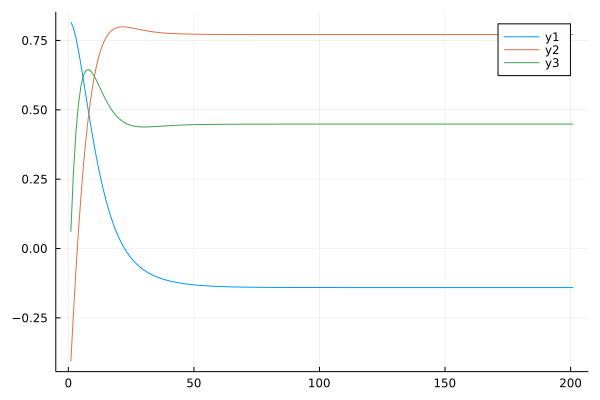

In [5]:
include("LiPoSID.jl")
seed = 100
w = 0.0
t = [0:0.01:2;]
ρ = LiPoSID.rand_Linblad_w_noise(seed, w, t)

using Plots
plot(LiPoSID.bloch(ρ)')

In [6]:
obj = pade_obj(ρ, t);

using TSSOS
opt,sol,data = tssos_first(obj, variables(obj));

************************TSSOS************************
TSSOS is launching...
Starting to compute the block structure...
------------------------------------------------------
The sizes of PSD blocks:
[41, 8]
[1, 1]
------------------------------------------------------
Obtained the block structure. The maximal size of blocks is 41.
Assembling the SDP...
There are 525 affine constraints.
Solving the SDP...
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 525             
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries      

In [7]:
opt,sol,data = tssos_higher!(data);

Starting to compute the block structure...
No higher TSSOS hierarchy!
